In [110]:
#pip install geopandas

In [98]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, decode, date_format
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, IntegerType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels
#import geopandas as gpd

In [3]:
# 
spark = SparkSession.builder \
    .appName("first_app") \
    .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.3.0") \
    .getOrCreate()

In [4]:
#

df = spark \
  .read \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "44.201.154.178:9092") \
  .option("subscribe", "health_events") \
  .option("startingOffsets", "earliest") \
  .load()

#

df = df.withColumn("decoded_value", decode(col("value"), "UTF-8"))

# Format the month from number to name
df = df.withColumn("month_name", date_format(col("timestamp"), "MMMM"))

In [5]:
# checkingn schema

df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)
 |-- decoded_value: string (nullable = true)
 |-- month_name: string (nullable = true)



In [25]:
#

schema = StructType([
    StructField("EventType", StringType(), True),
    StructField("Timestamp", TimestampType(), True),
    StructField("Location", StringType(), True),
    StructField("Severity", StringType(), True),
    StructField("Details", StringType(), True)
])


In [26]:
# 

"""parsed_df = df.select(
    col("key").cast("string"),
    from_json(col("decoded_value").cast("string"), json_schema).alias("data"),
    "topic",
    "partition",
    "offset",
    "timestamp",
)"""


'parsed_df = df.select(\n    col("key").cast("string"),\n    from_json(col("decoded_value").cast("string"), json_schema).alias("data"),\n    "topic",\n    "partition",\n    "offset",\n    "timestamp",\n)'

In [27]:
#

"""exploded_df = parsed_df.select(
    "key",
    "data.EventType",
    "data.TimeStamp",
    "data.Location",
    "data.Severity",
    "data.Details",
    "topic",
    "partition",
    "offset",
    "timestamp"
)

# check new dataframe

exploded_df.show(truncate=False)"""

'exploded_df = parsed_df.select(\n    "key",\n    "data.EventType",\n    "data.TimeStamp",\n    "data.Location",\n    "data.Severity",\n    "data.Details",\n    "topic",\n    "partition",\n    "offset",\n    "timestamp"\n)\n\n# check new dataframe\n\nexploded_df.show(truncate=False)'

In [31]:
# export spark dataframe to pandas dataframe
df_with_json = df.withColumn("json_data", from_json(col("decoded_value"), schema))

# Expanding the JSON data into separate columns
df_expanded = df_with_json.select(
    "decoded_value",
    col("json_data.EventType").alias("EventType"),
    col("json_data.Timestamp").alias("Timestamp"),
    col("json_data.Location").alias("Location"),
    col("json_data.Severity").alias("Severity"),
    col("json_data.Details").alias("Details")
)

df_expanded.show(truncate=False)

pandas_df = df_expanded.toPandas()

# preview pandas dataframe

pandas_df

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------+-----------+--------+------------------------------------------------+
|decoded_value                                                                                                                                                                             |EventType            |Timestamp          |Location   |Severity|Details                                         |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------+-------------------+-----------+--------+------------------------------------------------+
|{"EventType": "emergency_incident", "Timestamp": "2024-04-10 02:14:41", "Location": "Paris", "Se

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


,decoded_value,EventType,Timestamp,Location,Severity,Details
0,"{""EventType"": ""emergency_incident"", ""Timestamp...",emergency_incident,2024-04-10 02:14:41,Paris,high,This is a simulated emergency_incident event.
1,"{""EventType"": ""emergency_incident"", ""Timestamp...",emergency_incident,2024-04-10 02:14:47,London,high,This is a simulated emergency_incident event.
2,"{""EventType"": ""routine_checkup"", ""Timestamp"": ...",routine_checkup,2024-04-10 02:15:03,Berlin,low,This is a simulated routine_checkup event.
3,"{""EventType"": ""routine_checkup"", ""Timestamp"": ...",routine_checkup,2024-04-10 02:15:12,Berlin,low,This is a simulated routine_checkup event.
4,"{""EventType"": ""general_health_report"", ""Timest...",general_health_report,2024-04-10 02:15:23,Los Angeles,medium,This is a simulated general_health_report event.
...,...,...,...,...,...,...
59750,"{""EventType"": ""emergency_incident"", ""Timestamp...",emergency_incident,2024-04-18 00:43:57,Berlin,high,This is a simulated emergency_incident event.
59751,"{""EventType"": ""general_health_report"", ""Timest...",general_health_report,2024-04-18 00:44:00,London,medium,This is a simulated general_health_report event.
59752,"{""EventType"": ""health_mention"", ""Timestamp"": ""...",health_mention,2024-04-18 00:44:03,Los Angeles,low,This is a simulated health_mention event.
59753,"{""EventType"": ""vaccination"", ""Timestamp"": ""202...",vaccination,2024-04-18 00:44:12,New York,low,This is a simulated vaccination event.


In [33]:
# drop any duplicates

pandas_df = pandas_df.drop_duplicates()

pandas_df

,decoded_value,EventType,Timestamp,Location,Severity,Details
0,"{""EventType"": ""emergency_incident"", ""Timestamp...",emergency_incident,2024-04-10 02:14:41,Paris,high,This is a simulated emergency_incident event.
1,"{""EventType"": ""emergency_incident"", ""Timestamp...",emergency_incident,2024-04-10 02:14:47,London,high,This is a simulated emergency_incident event.
2,"{""EventType"": ""routine_checkup"", ""Timestamp"": ...",routine_checkup,2024-04-10 02:15:03,Berlin,low,This is a simulated routine_checkup event.
3,"{""EventType"": ""routine_checkup"", ""Timestamp"": ...",routine_checkup,2024-04-10 02:15:12,Berlin,low,This is a simulated routine_checkup event.
4,"{""EventType"": ""general_health_report"", ""Timest...",general_health_report,2024-04-10 02:15:23,Los Angeles,medium,This is a simulated general_health_report event.
...,...,...,...,...,...,...
59750,"{""EventType"": ""emergency_incident"", ""Timestamp...",emergency_incident,2024-04-18 00:43:57,Berlin,high,This is a simulated emergency_incident event.
59751,"{""EventType"": ""general_health_report"", ""Timest...",general_health_report,2024-04-18 00:44:00,London,medium,This is a simulated general_health_report event.
59752,"{""EventType"": ""health_mention"", ""Timestamp"": ""...",health_mention,2024-04-18 00:44:03,Los Angeles,low,This is a simulated health_mention event.
59753,"{""EventType"": ""vaccination"", ""Timestamp"": ""202...",vaccination,2024-04-18 00:44:12,New York,low,This is a simulated vaccination event.


In [34]:
pandas_df['EventType'].value_counts()

routine_checkup          10070
general_health_report    10068
vaccination               9982
emergency_incident        9913
health_mention            9811
hospital_admission        9806
Name: EventType, dtype: int64

In [35]:
pandas_df['Location'].value_counts()

London         10048
Berlin          9970
Paris           9963
Los Angeles     9930
New York        9873
Boston          9866
Name: Location, dtype: int64

In [36]:
pandas_df['Severity'].value_counts()

medium    24897
low       19962
high      14791
Name: Severity, dtype: int64

In [38]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59650 entries, 0 to 59754
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   decoded_value  59650 non-null  object        
 1   EventType      59650 non-null  object        
 2   Timestamp      59650 non-null  datetime64[ns]
 3   Location       59650 non-null  object        
 4   Severity       59650 non-null  object        
 5   Details        59650 non-null  object        
dtypes: datetime64[ns](1), object(5)
memory usage: 3.2+ MB


In [40]:
# Assuming 'df' is your DataFrame
pandas_df.describe() # For numerical columns

/tmp/ipykernel_5477/1282139562.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  pandas_df.describe() # For numerical columns


,decoded_value,EventType,Timestamp,Location,Severity,Details
count,59650,59650,59650,59650,59650,59650
unique,59650,6,59650,6,3,6
top,"{""EventType"": ""emergency_incident"", ""Timestamp...",routine_checkup,2024-04-10 02:14:41,London,medium,This is a simulated routine_checkup event.
freq,1,10070,1,10048,24897,10070
first,NaN,NaN,2024-04-10 02:14:41,NaN,NaN,NaN
last,NaN,NaN,2024-04-18 00:44:18,NaN,NaN,NaN


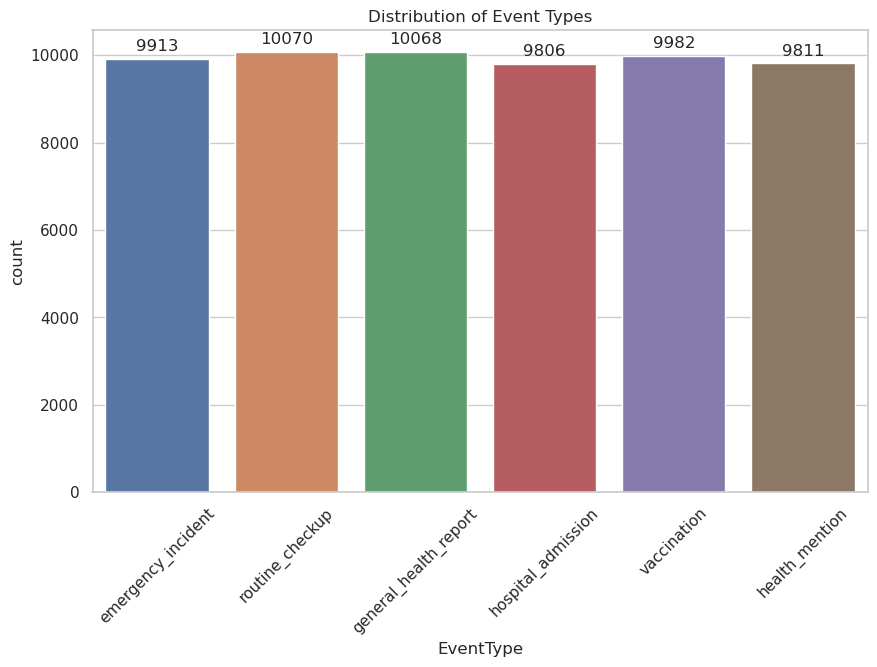

In [47]:
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='EventType', data=pandas_df)
plt.title('Distribution of Event Types')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # text to display
                (p.get_x() + p.get_width() / 2., p.get_height()),  # point to annotate
                ha='center', va='center',  # center alignment
                xytext=(0, 9),  # distance from text to points (x,y)
                textcoords='offset points')  # use offset points

plt.show()


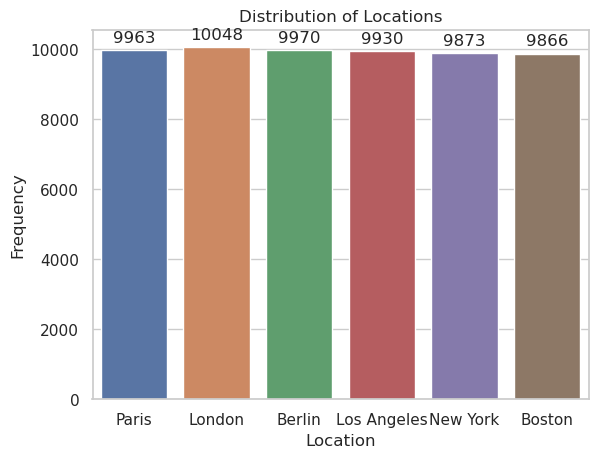

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

ax = sns.countplot(x='Location', data=pandas_df)
plt.title('Distribution of Locations')
plt.xlabel('Location')
plt.ylabel('Frequency')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # text to display
                (p.get_x() + p.get_width() / 2., p.get_height()),  # point to annotate
                ha='center', va='center',  # center alignment
                xytext=(0, 9),  # distance from text to points (x,y)
                textcoords='offset points')  # use offset points

plt.show()


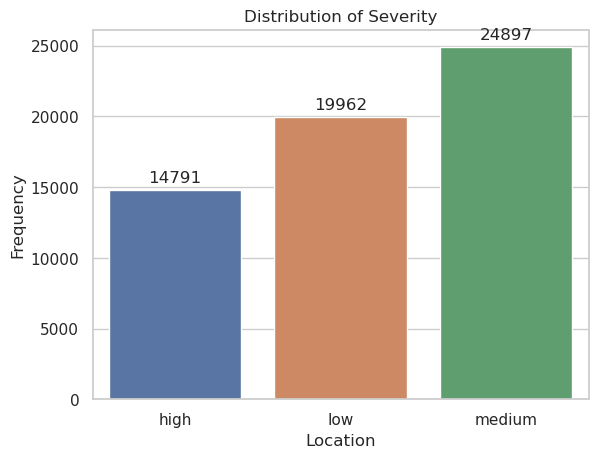

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

ax = sns.countplot(x='Severity', data=pandas_df)
plt.title('Distribution of Severity')
plt.xlabel('Location')
plt.ylabel('Frequency')
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',  # text to display
                (p.get_x() + p.get_width() / 2., p.get_height()),  # point to annotate
                ha='center', va='center',  # center alignment
                xytext=(0, 9),  # distance from text to points (x,y)
                textcoords='offset points')  # use offset points

plt.show()

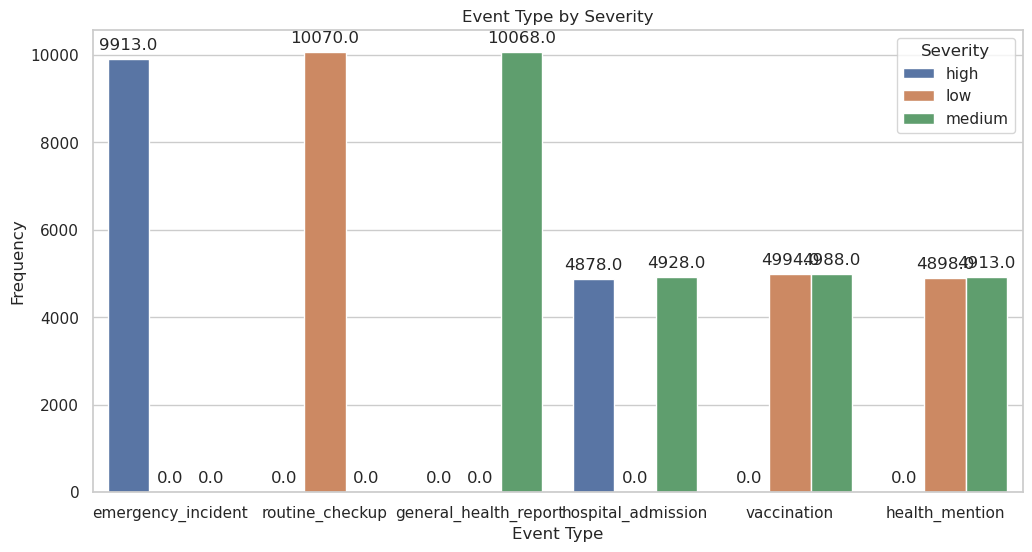

In [58]:
# Relationship between event type and severity
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='EventType', hue='Severity', data=pandas_df)
plt.title('Event Type by Severity')
plt.xlabel('Event Type')
plt.ylabel('Frequency')
plt.legend(title='Severity')
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                xytext = (0, 10), 
                textcoords = 'offset points')

plt.show()


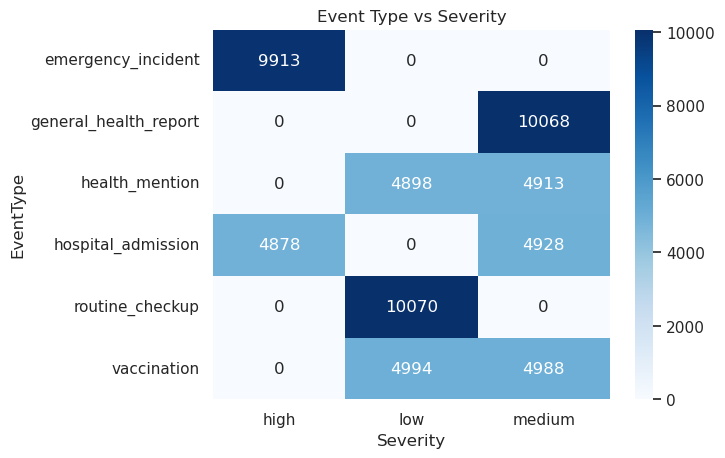

In [61]:
event_severity = pd.crosstab(pandas_df['EventType'], pandas_df['Severity'])
sns.heatmap(event_severity, annot=True, cmap='Blues', fmt='d')
plt.title('Event Type vs Severity')
plt.show()


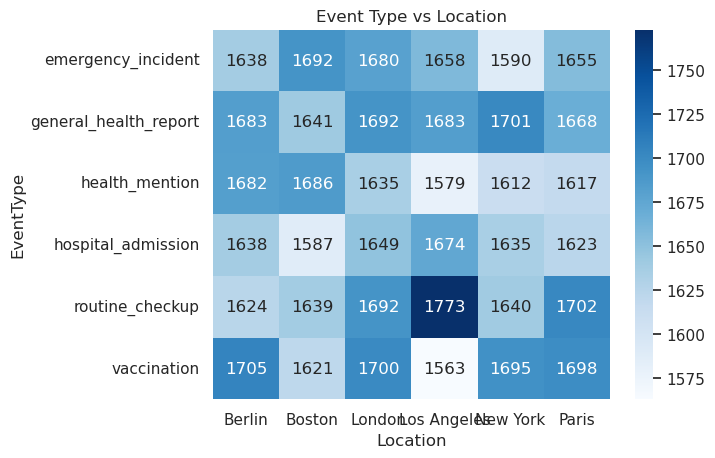

In [74]:
event_severity = pd.crosstab(pandas_df['EventType'], pandas_df['Location'])
sns.heatmap(event_severity, annot=True, cmap='Blues', fmt='d')
plt.xticks(rotation=0)  
plt.yticks(rotation=0)  
plt.title('Event Type vs Location')
plt.show()


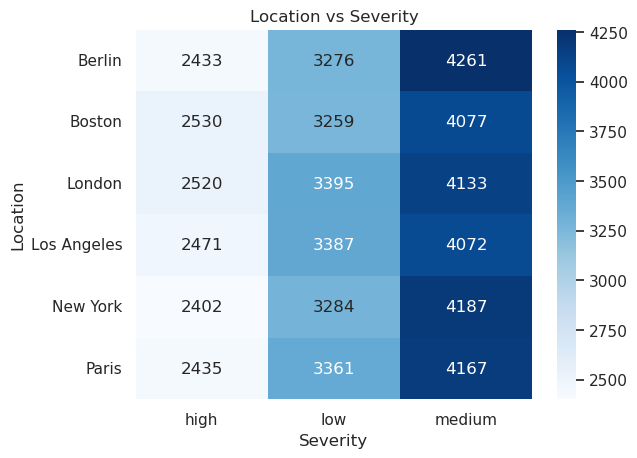

In [67]:
event_severity = pd.crosstab(pandas_df['Location'], pandas_df['Severity'])
sns.heatmap(event_severity, annot=True, cmap='Blues', fmt='d')
plt.title('Location vs Severity')
plt.show()


In [86]:
contingency_table = pd.crosstab(pandas_df['EventType'], pandas_df['Severity'])

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p_value)

def cramers_v(chi2, n, k, r):
    """Calculate Cramér's V statistic for a given Chi-squared and sample size."""
    # k - number of columns, r - number of rows
    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    r_corr = r - ((r-1)**2)/(n-1)
    k_corr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Calculate Cramér's V
n = pandas_df.shape[0]  # Total sample size
k = len(contingency_table.columns)
r = len(contingency_table.index)
v = cramers_v(chi2, n, k, r)

print("Cramér's V:", v)


Chi-square statistic: 76898.79867852968
P-value: 0.0
Cramér's V: 0.8028207638488675


In [87]:
contingency_table = pd.crosstab(pandas_df['EventType'], pandas_df['Location'])

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p_value)


# Calculate Cramér's V
n = pandas_df.shape[0]  # Total sample size
k = len(contingency_table.columns)
r = len(contingency_table.index)
v = cramers_v(chi2, n, k, r)

print("Cramér's V:", v)



Chi-square statistic: 30.57571820076236
P-value: 0.2034543427773363
Cramér's V: 0.004323764799419617


In [88]:
contingency_table = pd.crosstab(pandas_df['Severity'], pandas_df['Location'])

# Perform the chi-square test
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square statistic:", chi2)
print("P-value:", p_value)


# Calculate Cramér's V
n = pandas_df.shape[0]  # Total sample size
k = len(contingency_table.columns)
r = len(contingency_table.index)
v = cramers_v(chi2, n, k, r)

print("Cramér's V:", v)



Chi-square statistic: 14.770244889983488
P-value: 0.14066553490168315
Cramér's V: 0.006323387042518085


<Figure size 1000x600 with 0 Axes>

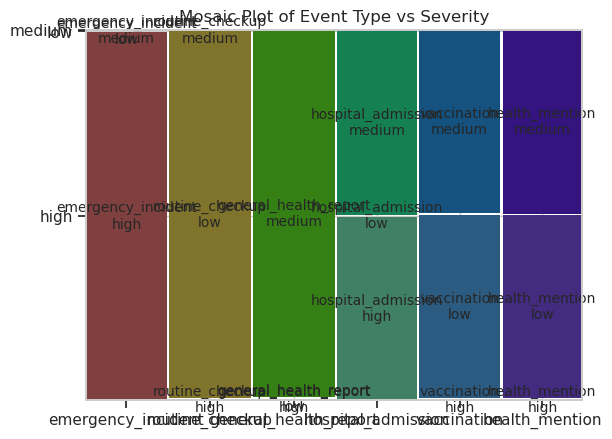

In [100]:
from statsmodels.graphics.mosaicplot import mosaic

plt.figure(figsize=(10, 6))
mosaic(pandas_df, ['EventType', 'Severity'], title='Mosaic Plot of Event Type vs Severity')
plt.show()

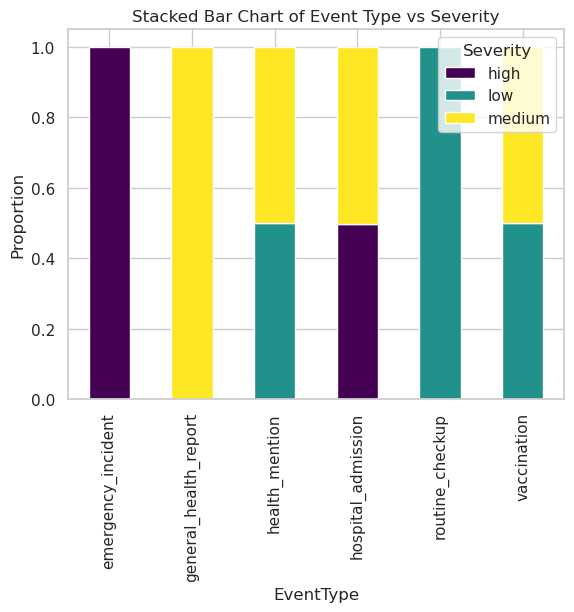

In [104]:
cross_tab = pd.crosstab(pandas_df['EventType'], pandas_df['Severity'])


cross_tab_prop = cross_tab.div(cross_tab.sum(1), axis=0)

cross_tab_prop.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Stacked Bar Chart of Event Type vs Severity')
plt.xlabel('EventType')
plt.ylabel('Proportion')
plt.legend(title='Severity')
plt.show()


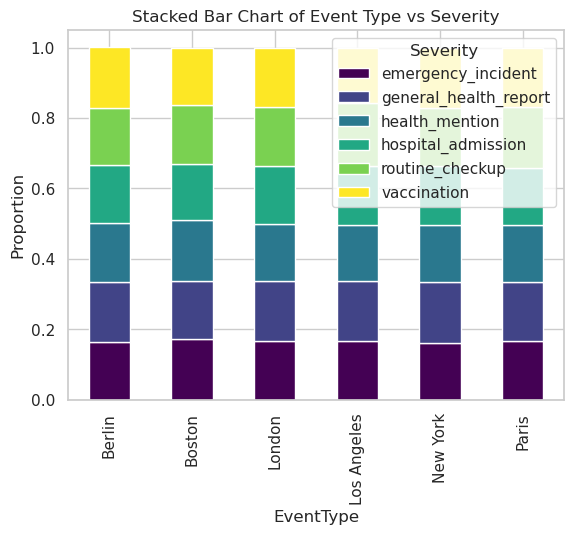

In [109]:
cross_tab = pd.crosstab(pandas_df['Location'], pandas_df['EventType'])


cross_tab_prop = cross_tab.div(cross_tab.sum(1), axis=0)

cross_tab_prop.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Stacked Bar Chart of Event Type vs Severity')
plt.xlabel('EventType')
plt.ylabel('Proportion')
plt.legend(title='Severity')
plt.show()


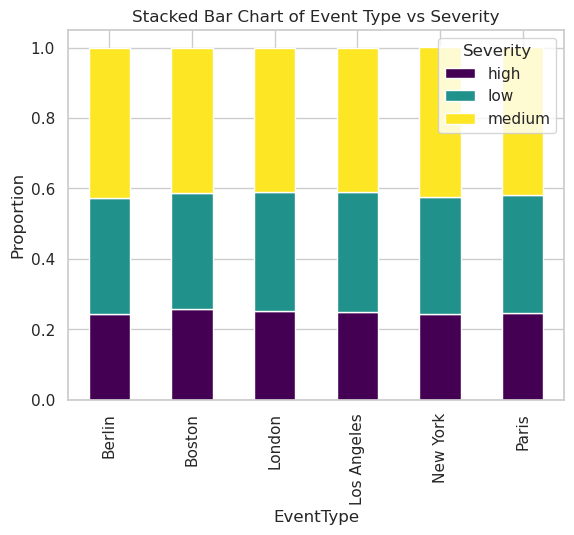

In [108]:
cross_tab = pd.crosstab(pandas_df['Location'], pandas_df['Severity'])


cross_tab_prop = cross_tab.div(cross_tab.sum(1), axis=0)

cross_tab_prop.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Stacked Bar Chart of Location vs Severity')
plt.xlabel('EventType')
plt.ylabel('Proportion')
plt.legend(title='Severity')
plt.show()
